In [ ]:
%pip install fastcore fastai  rasterio geopandas shapely wandb geojson -Uqq

     |████████████████████████████████| 56 kB 3.3 MB/s 
     |████████████████████████████████| 189 kB 13.5 MB/s 
     |████████████████████████████████| 19.3 MB 404 kB/s 
     |████████████████████████████████| 1.0 MB 47.9 MB/s 
     |████████████████████████████████| 1.7 MB 47.6 MB/s 
     |████████████████████████████████| 6.3 MB 45.2 MB/s 
     |████████████████████████████████| 15.4 MB 33.5 MB/s 
     |████████████████████████████████| 140 kB 64.5 MB/s 
     |████████████████████████████████| 180 kB 51.2 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


In [ ]:
#hide
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
#hide
from fastai.vision.models import *
from fastai.vision.all import *

from tqdm import tqdm
from pdb import set_trace
from pprint import pprint
from pathlib import Path
import wandb
from fastai.callback.wandb import * 

warnings.filterwarnings("ignore")

path = Path('/content/drive/My Drive/cv/cv_527/xview_data/test')
type(path)
Path.BASE_PATH = path

In [ ]:
#hide
# Checking what Google Colab is offering today :)
try:
  torch.cuda.get_device_properties(0)
except:
  print("No CUDA device available.")

Defining training parameters:

In [ ]:
BATCH_SIZE = 12 
TILES_PER_SCENE = 16
ARCHITECTURE = xresnet34
EPOCHS = 40
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 3e-3
ENCODER_FACTOR = 10
CODES = ['Land','Building']

In [ ]:
#hide
# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    tiles_per_scene=TILES_PER_SCENE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

In [ ]:
def get_image_tiles(path:Path, n_tiles=TILES_PER_SCENE) -> L:
  "Returns a list of the first `n` image tile filenames in `path`"
  files = L()
  masked_files = (path/'mask_tiles').ls().sorted()

  for fi in masked_files:
    files.append(Path(str(fi).replace("mask_tiles", "img_tiles")))

  return files

def get_y_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('img_tiles', 'mask_tiles')

def get_x_fn(fn:Path) -> str:
  "Returns filename of the associated mask tile for a given image tile"
  return str(fn).replace('mask_tiles', 'img_tiles')


def get_y(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_y_fn(fn)
  msk = np.array(PILMask.create(fn))
  msk[msk==255] = 1
  return PILMask.create(msk)

def get_x(fn:Path) -> PILMask:
  "Returns a PILMask object of 0s and 1s for a given tile"
  fn = get_x_fn(fn)
  # print("fn return ", fn)
  msk = np.array(PILMask.create(fn))
  return (msk)


To explore how imbalanced the data is exactly, we'll analyze the percentages of building pixels in each tile. We create a simple dataloader to easily load and analyze the masks.

In [ ]:
ALL_VALID_NAMES = [
'mexico-earthquake_00000015_post_disaster'
]


def get_input_images(path):
  mask_contained_images = []
  mask_files = (path/'mask_tiles').ls().sorted()
  non_existing_files = ['/content/drive/My Drive/projects/cv_527/xview_data/train/mask_tiles/guatemala-volcano_00000007_pre_disaster_0_2 (1).png', 'uatemala-volcano_00000001_pre_disaster_1_2 (1)']
  for mk_f in mask_files:
    if mk_f not in non_existing_files:
      new_p = Path(str(mk_f).replace("mask_tiles", "img_tiles3"))
      mask_contained_images.append(new_p)
  # print("mask_contained_images ", mask_contained_images)
  return mask_contained_images

import pdb

def get_target_mask(path):
  # print("path , ",path) 
  new_p = Path(str(path).replace( "img_tiles", "mask_tiles"))
  return (new_p)
  
def valid_split(item):
  # pdb.set_trace()
  scene = item.parent.parent.name
  short_name = item.name[:-8]
  
  return short_name in ALL_VALID_NAMES

#collapse
def has_buildings(fn:Path) -> bool:
  """Returns whether the mask of a given image tile
  contains at least one pixel of a building"""
  fn = get_y_fn(fn)
  msk = tensor(PILMask.create(fn))
  count = torch.count_nonzero(msk)
  return count>0.

import os.path


#collapse
def get_undersampled_tiles(path:Path) -> L:
  """Returns a list of image tile filenames in `path`.
  For tiles in the training set, empty tiles are ignored.
  All tiles in the validation set are included."""

  files = get_image_tiles(path)
  print(files[0])
  train_idxs, valid_idxs = FuncSplitter(valid_split)(files)
  # print("train_idxs, valid_idxs ", train_idxs, valid_idxs )
  print("train_idxs, valid_idxs ", len(train_idxs), len(valid_idxs) )

  tot_len =  len(train_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)
  # tot_len = 100
  print("train_files pre ", len(train_idxs) )
  # block_len = int(tot_len * 0.4)
  train_files = L(filter(has_buildings, files[train_idxs]))[:tot_len]
  print("train_files ", len(train_files) )
  print("train_files tot_len ", (tot_len) )

  # train_files = L(filter(has_buildings, files[exist_file_indexes]))


  tot_len =  len(valid_idxs)
  tot_len = tot_len - (tot_len % BATCH_SIZE)

  valid_files = files[valid_idxs][:tot_len]
  print("valid_files ", valid_files)


  return train_files #+ valid_files


In [ ]:
files = ((path/'mask_tiles').ls())
# for ele in files:
#   print(str(ele))
len(files)

24060

In [ ]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Resize(255, method=ResizeMethod.Squish),
        Normalize.from_stats(*imagenet_stats)]

To create the datasets, we use the convenient DataBlock API of fastai. We only load 16 tiles per scene, so only 1 image per region.

In [ ]:
tiles = DataBlock(
      blocks = (ImageBlock(),MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_tiles,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      # splitter = FuncSplitter(valid_split),           # Split into training and validation set
      splitter = RandomSplitter(valid_pct=0.5, seed=42),
      # batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )                              

In [ ]:
# tiles.summary(path)
dls = tiles.dataloaders(path, bs=40)
dls_seq_net = tiles.dataloaders(path, bs=8)
dls = tiles.dataloaders(path, bs=BATCH_SIZE)
dls.vocab = CODES
dls_eff = tiles.dataloaders(path, bs=16, drop_last=True)

/content/drive/My Drive/cv/cv_527/xview_data/test/img_tiles/guatemala-volcano_00000003_post_disaster_1_0.png
train_idxs, valid_idxs  24060 0
train_files pre  24060
train_files  12921
train_files tot_len  24060
valid_files  []
/content/drive/My Drive/cv/cv_527/xview_data/test/img_tiles/guatemala-volcano_00000003_post_disaster_1_0.png
train_idxs, valid_idxs  24060 0
train_files pre  24060
train_files  12921
train_files tot_len  24060
valid_files  []
/content/drive/My Drive/cv/cv_527/xview_data/test/img_tiles/guatemala-volcano_00000003_post_disaster_1_0.png
train_idxs, valid_idxs  24060 0
train_files pre  24060
train_files  12921
train_files tot_len  24060
valid_files  []
/content/drive/My Drive/cv/cv_527/xview_data/test/img_tiles/guatemala-volcano_00000003_post_disaster_1_0.png
train_idxs, valid_idxs  24060 0
train_files pre  24060
train_files  12921
train_files tot_len  24060
valid_files  []


In [ ]:
#  torch.save(dls, '/content/drive/My Drive/projects/cv_527/short_dataloader.pth')
# torch.load(dls, '/content/drive/My Drive/projects/cv_527/short_dataloader.pth')


In [ ]:
tiles.summary(path)


With some experimentation, the class weights 0.25 for the background and 0.75 for the building class seem to work fine.

In [ ]:
weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)

learn = unet_learner(dls,                                 # DataLoaders
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )]
                     )

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

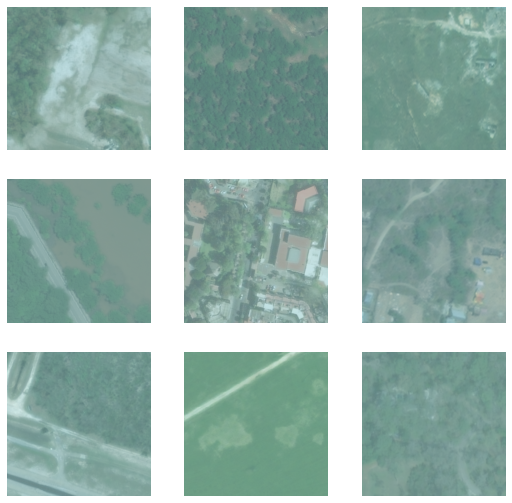

In [ ]:
# for batch in dls:
#     print(batch.) # or anything else you want to do
#     break

dls.show_batch()


In [ ]:
learn.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/unet_learner')
# learn.recorder.plot
# learn.recorder.plot_metrics()


In [ ]:
%pip install timm

     |████████████████████████████████| 376 kB 9.9 MB/s 


In [ ]:
#exports
def _get_params_from_attrs(m, ls): return params(nn.Sequential(*getattrs(m, *ls)))
def _get_params_from_modules(modules): return params(nn.Sequential(*modules))

def split_nested_list(l, idxs, left_in=None, right_in=None):
    left_in,right_in = ifnone(left_in,L()),ifnone(right_in,L())
    idx = int(idxs[0])
    if len(idxs)==1: left,right = l[:idx],l[idx:]
    else: left,right = split_nested_list(l[idx], idxs[1:], l[:idx], l[idx+1:])
    return L(L(*left_in,*left), L(*right,*right_in))

def _timm_splitter(m):
    encoder_module_names = L(m.encoder._modules)
    encoder_split_idxs = m.feature_info.module_name(0).split('.')
    # the first idx is a (unique) name so we convert it to a numerical idx
    encoder_split_idxs[0] = encoder_module_names.index(encoder_split_idxs[0])
    encoder_modules = getattrs(m.encoder,*encoder_module_names)
    encoder_early,encoder_late = split_nested_list(encoder_modules,encoder_split_idxs)
    encoder_early = _get_params_from_modules(encoder_early)
    encoder_late = _get_params_from_modules(encoder_late)
    decoder = _get_params_from_attrs(m.decoder, L(m.decoder._modules))
    head = _get_params_from_attrs(m.head, L(m.head._modules))
    return L(encoder_early, encoder_late, L(*decoder, *head))

#export
def _timm_stats(m): return tuple((list(m.default_cfg[stat]) for stat in ('mean','std')))


import timm
#export
from typing import List
#export
from timm import create_model
from fastai.vision.learner import _update_first_layer


#exports
class DecoderBlock(Module):
    """
    Decoder Block based off https://gist.github.com/rwightman/f8b24f4e6f5504aba03e999e02460d31
    """
    def __init__(self, up_in_c, s_in_c, scale=2, blur=False,  final_div=True,
                 act_cls=defaults.activation, init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, scale=scale, blur=blur, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.bn = BatchNorm(s_in_c)
        self.act = act_cls()
        ni = up_in_c//2 + s_in_c
        nf = ni if final_div else ni//2
        self.nf = nf
        self.conv1 = ConvLayer(ni, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, act_cls=act_cls, norm_type=norm_type, **kwargs)
        apply_init(nn.Sequential(self.shuf, self.bn, self.conv1, self.conv2), init)

    def forward(self, up_in: torch.Tensor, skip: Optional[torch.Tensor] = None):
        x = self.shuf(up_in)
        if skip is not None:
            ssh = skip.shape[-2:]
            if ssh != x.shape[-2:]:
                x = F.interpolate(x, ssh, mode='nearest')
            x = self.act(torch.cat([x, self.bn(skip)], dim=1))
        return self.conv2(self.conv1(x))

#exports
@delegates(nn.BatchNorm2d)
def BatchNormZero(nf, ndim=2, **kwargs):
    "BatchNorm layer with `nf` features and `ndim` initialized depending on `norm_type`. Weights initialized to zero."
    return _get_norm('BatchNorm', nf, ndim, zero=True, **kwargs)


def _make_bottleneck(bottleneck, ni, act_cls=defaults.activation, norm_type=None, init=nn.init.kaiming_normal_, **kwargs):
    if bottleneck == 'conv':
        seq = nn.Sequential(BatchNorm(ni), nn.ReLU(),
                            ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
    elif bottleneck == 'attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    elif bottleneck == 'double_attention':
        seq = nn.Sequential(BatchNormZero(ni), nn.ReLU(),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1),
                            ConvLayer(ni, ni, act_cls=act_cls, norm_type=norm_type, **kwargs),
                            SimpleSelfAttention(ni, ks=1))
    else: raise NotImplementedError(f'Bottleneck architecture {bottleneck} not implemented.')
    apply_init(seq, init)
    return seq

#exports
class UnetDecoder(Module):
   
    def __init__(self, encoder, bottleneck=None, blur=False, blur_final=True,
                 norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, **kwargs):
        

        encoder_chs = encoder.feature_info.channels()[::-1]
        encoder_reds = encoder.feature_info.reduction()
        skip_channels = L(encoder_chs[1:])

        self.blocks = nn.ModuleList()
        up_c = encoder_chs[0]
        self.bottleneck = _make_bottleneck(bottleneck, up_c, act_cls=act_cls, norm_type=norm_type, init=init, **kwargs) if isinstance(bottleneck,str) else bottleneck
        for i,skip_c in enumerate(skip_channels):
            not_final = i!=len(skip_channels)-1
            do_blur = blur and (not_final or blur_final)
            scale = encoder_reds.pop()//encoder_reds[-1]
            block = DecoderBlock(up_c, skip_c, scale=scale, blur=do_blur, final_div=not_final, act_cls=act_cls, init=init, norm_type=norm_type, **kwargs)
            up_c = block.nf
            self.blocks.append(block)

        scale = encoder_reds[0]
        self.final_shuf = PixelShuffle_ICNR(up_c, scale=scale, act_cls=act_cls, norm_type=norm_type, **kwargs) if scale!= 1 else None
        self.nf = up_c

    def forward(self, x: List[torch.Tensor]):
        x.reverse()  # torchscript doesn't work with [::-1]
        skips = x[1:]
        x = x[0]
        if self.bottleneck is not None: x = self.bottleneck(x)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        if self.final_shuf is not None: x = self.final_shuf(x)
        return x


#exports
class UnetHead(SequentialEx):
   
    def __init__(self, up_c, n_out, last_cross=False, n_in=None, bottle=False, norm_type=None, act_cls=defaults.activation, init=nn.init.kaiming_normal_, y_range=None, **kwargs):
        layers = nn.ModuleList([ResizeToOrig()])
        if last_cross:
            if n_in is None: raise AttributeError('You must specify `n_in` if `last_cross=True`.')
            up_c += n_in
            layers.extend([MergeLayer(dense=True), ResBlock(1, up_c, up_c//2 if bottle else up_c, act_cls=act_cls, norm_type=norm_type, **kwargs)])
        layers.append(nn.Conv2d(up_c, n_out, kernel_size=(1, 1)))
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)
        apply_init(self, init)


#exports
class TimmUnet(SequentialEx):
   

    def __init__(self, encoder='resnet50', n_in=3, n_out=1, encoder_kwargs=None, encoder_indices=None,
                 blur=False, blur_final=True,
                 bottleneck=None, last_cross=True, norm_type=None, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, pretrained=True, y_range=None, bottle=False, **kwargs):
        encoder_kwargs = encoder_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        self.encoder = create_model(encoder, features_only=True, out_indices=encoder_indices, in_chans=n_in,
                                    pretrained=pretrained, **encoder_kwargs)

        self.decoder = UnetDecoder(self.encoder, bottleneck=bottleneck, blur=blur, blur_final=blur_final,
                                   norm_type=norm_type, act_cls=act_cls, init=init, **kwargs)

        self.head = UnetHead(self.decoder.nf, n_out, last_cross=last_cross, n_in=n_in, bottle=bottle,
                             norm_type=norm_type, act_cls=act_cls, init=init, y_range=y_range, **kwargs)
        super().__init__(nn.Sequential(self.encoder, self.decoder), *self.head)

    @property
    def default_cfg(self): return self.encoder.default_cfg
    @property
    def feature_info(self): return self.encoder.feature_info

def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    print("meta ", meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, **kwargs)
    # learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

#exports
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    print("body ", body)
    print("*body.children() sda ", *body.children())
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


#export
from fastai.vision.learner import _add_norm

#exports
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    print("y_range ", y_range)
    print("n_out ", n_out)
    print("config ", config)
    print("default_split ", default_split)
    model = create_timm_model(arch, n_out,  pretrained = pretrained, y_range=y_range, **config)
    # learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    learn = Learner(dls, model, loss_func=loss_func,  **kwargs)

    if pretrained: learn.freeze()
    return learn


#export
@delegates(TimmUnet.__init__)
def timm_unet_learner(dls, arch, normalize=True, n_in=None, n_out=None, pretrained=True,
                 # learner args
                 loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=True, moms=(0.95,0.85,0.95),
                 # other model args
                 bottleneck='conv',
                 **kwargs):
    
    n_in = ifnone(n_in, dls.one_batch()[0].shape[1])
    n_out = ifnone(n_out, get_c(dls))
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    model = TimmUnet(arch, n_in=n_in, n_out=n_out, pretrained=pretrained, bottleneck=bottleneck, **kwargs)

    if normalize: _add_norm(dls, {'stats': _timm_stats(model)}, pretrained)
    splitter=ifnone(splitter, _timm_splitter)
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, splitter=splitter, cbs=cbs,
                   metrics=metrics, path=path, model_dir=model_dir, wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn,
                   moms=moms)
    if pretrained: learn.freeze()
    # keep track of args for loggers
    store_attr('arch,normalize,n_out,pretrained', self=learn, **kwargs)
    return learn


In [ ]:


# lr_max = LR_MAX 

learn_eff = timm_unet_learner(dls_eff, 'efficientnet_b1', metrics = [Dice(), foreground_acc], cbs=CSVLogger())
# learn_seqnet.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_20');
learn_eff.load('/content/drive/My Drive/cv/cv_527/xview_data/learners_model/eff_unet_learner')

from fastai.vision.models import squeezenet1_0
mobilenet = squeezenet1_0
archi_seq = mobilenet #(pretrained=True)

weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)
# print( (Path.cwd()/f'tmp/models/model_.pth').exists() )
pa = '/content/drive/My Drive/cv/cv_527/xview_data/train/squeeze_net_models/'
# for i in range(4): print((Path.cwd()/f'tmp/models/model_{i}.pth').exists())

import os

# arr = os.listdir('/tmp/models/')
# print(arr)


learn_seqnet = unet_learner(dls_seq_net,                                 # DataLoaders
                     archi_seq,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )],
                     path=pa
                     )

learn_seqnet.load(f'/content/drive/My Drive/cv/cv_527/xview_data/learners_model/mobile_unet_learner_20');



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

In [ ]:
name_paths

In [ ]:
def dice_score(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

all_test_files = []
for ele in (path/'mask_tiles').ls():
  try:
    all_test_files.append( ( (str(ele).replace( "mask_tiles" , "img_tiles")) , (str(ele)) ) )
  except Exception as e:
    print(e)

print("len all test files , ", all_test_files)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


In [ ]:
from fastai.vision.all import *

__all__ = ['DiceLoss', 'CombinedLoss']


def _one_hot(x, classes, axis=1):
    "Target mask to one hot"
    print("type ", type(x))
    print("classes ", classes)
    return torch.stack([torch.where(x==c, 1,0) for c in range(classes)], axis=axis)

class DiceLoss:
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1, smooth=1): 
        store_attr()
    def __call__(self, pred, targ):
        targ = _one_hot(targ, pred.shape[1])
        pred, targ = flatten_check(self.activation(pred), targ)
        inter = (pred*targ).sum()
        union = (pred+targ).sum()
        return 1 - (2. * inter + self.smooth)/(union + self.smooth)
    
    def activation(self, x): return F.softmax(x, dim=self.axis)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    

In [ ]:
%pip install -U segmentation-models-pytorch

In [ ]:
#export
from fastai.imports import *
from fastai.torch_imports import *
from fastai.torch_core import *
from fastai.layers import *
from torchvision import transforms
import gc

ind = 0
resnet_dice = []
seq_dice = []
eff_dice = []

tot = len(all_test_files)

for im, mask in tqdm(all_test_files[:tot//7]):
  im_m = PILImage.create(im)
  mask_m = Image.open(mask)
  mask_tensor = cast(array(mask_m), TensorMask)
  pre = learn.predict(im_m)
  pre_seq = learn_seqnet.predict(im_m)
  pre_eff = learn_eff.predict(im_m)

  dice_score = dice_coeff(pre[0].to(torch.uint8), mask_tensor, reduce_batch_first=False)

  resnet_dice.append(dice_score )
  dice_seq = dice_coeff(pre_seq[0].to(torch.uint8), mask_tensor, reduce_batch_first=False)
  dice_eff = dice_coeff(pre_eff[0].to(torch.uint8), mask_tensor, reduce_batch_first=False)

  seq_dice.append( dice_seq )
  eff_dice.append( dice_eff)

  if ind % 100 == 0:
    gc.collect()

  ind += 1

print(resnet_dice)
print("-------------")
print(seq_dice)
print("----------------")
print(eff_dice)

In [ ]:
resnet_sum = 0
for k in resnet_dice:
  resnet_sum += k

print(resnet_sum/len(resnet_dice), len(resnet_dice))

resnet_sum = 0
for k in eff_dice:
  resnet_sum += k

print(resnet_sum/len(eff_dice), len(eff_dice))

resnet_sum = 0
for k in seq_dice:
  resnet_sum += k

print(resnet_sum/len(seq_dice), len(seq_dice))

TensorMask(0.4508) 3437
TensorMask(0.4647) 3437
TensorMask(0.3580) 3437


In [ ]:
import gc
gc.collect()

390

In [ ]:
dir(learn.dls)

In [ ]:
import fastai.metrics


### Plot some examples with low losses

Tile #733, loss: 6.0310298977128696e-09
Tile #2368, loss: 4.919603835418229e-09
Tile #2372, loss: 4.051529778337226e-09


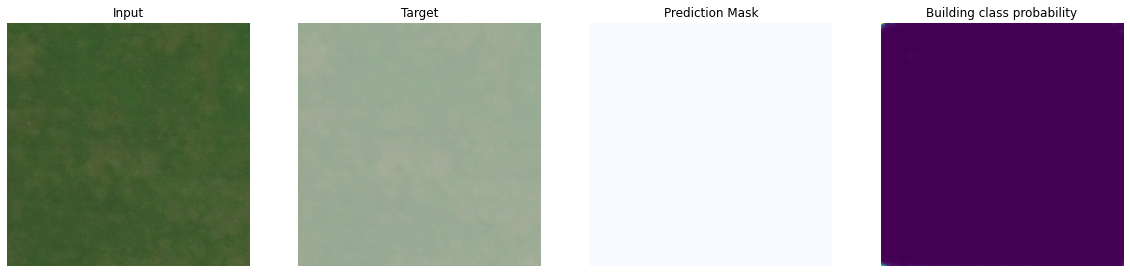

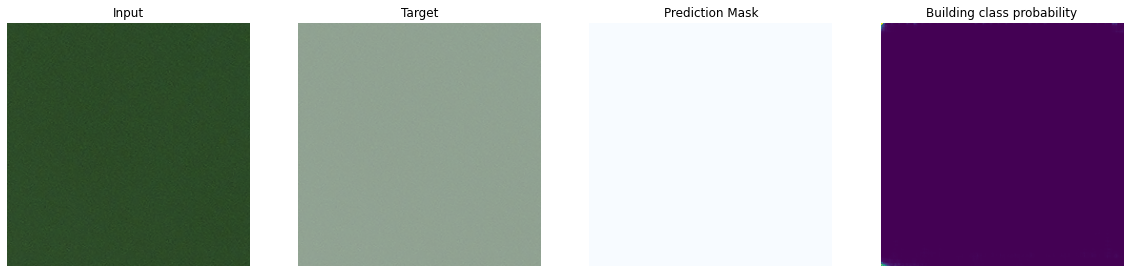

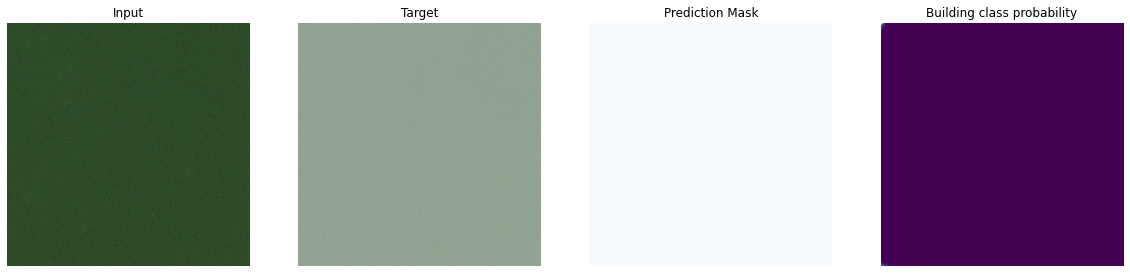

In [ ]:
#collapse
for idx in loss_sorted[-21:-18]:
  print(f'Tile #{idx}, loss: {losses[idx]}')
  show_single_pred(idx)

The model shows mixed performance in images with few buildings in them. Overall, the accuracy looks better here than in dense areas. But the model tends to produce false positives; and some tiles show weird artifacts in the corners. It seems as if the model interprets the corners itself as buildings, especially on tiles covered with water.

### Show complete scenes

Predict all tiles of a scene:

In [ ]:
#collapse
def save_predictions(scene, path=path) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  tiles = get_image_files(path/'img_tiles').sorted()
  for i in range(16):
    tile_preds = learn.predict(tiles[i])
    to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')


#collapse
def save_predictions(image) -> None:
  "Predicts all 16 tiles of one scene and saves them to disk"
  output_folder = path/'predicted_tiles'
  tile_preds = learn.predict(image)
  to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{image.name}')
  # if not os.path.exists(output_folder):
  #   os.makedirs(output_folder)
  # tiles = get_image_files(path/'img_tiles').sorted()
  # for i in range(16):
  #   tile_preds = learn.predict(tiles[i])
  #   to_image(tile_preds[2][1].repeat(3,1,1)).save(output_folder/f'{i:02d}.png')

In [ ]:
scene = VALID_SCENES[0] # 'L15-0571E-1075N_2287_3888_13'

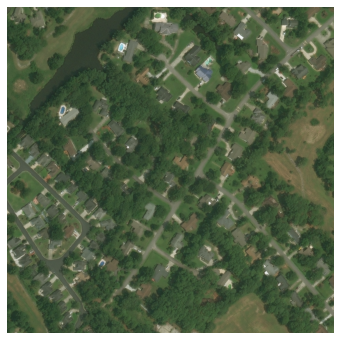

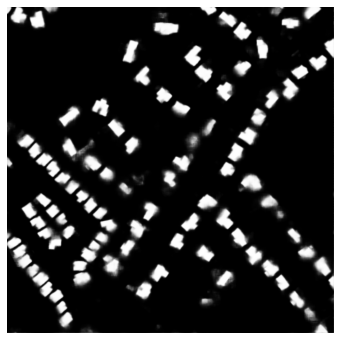

In [ ]:
# image.show()
# show_image(image)
output_folder = path/'predicted_tiles'
show_image(PILImage.create(image), figsize=(6,6));
show_image(PILImage.create(output_folder/f'{image.name}'), figsize=(6,6));

In [ ]:
save_predictions(image)

Helper function to show several tiles as a large image:

In [ ]:
#collapse
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.

    Source: https://stackoverflow.com/a/16873755
    """
    try: # with color channel
      n, nrows, ncols, c = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols, c)
                .swapaxes(1,2)
                .reshape(h, w, c))
    except ValueError: # without color channel
      n, nrows, ncols = arr.shape
      return (arr.reshape(h//nrows, -1, nrows, ncols)
                .swapaxes(1,2)
                .reshape(h, w))

Load saved predictions:

In [ ]:
#collapse
def get_saved_preds(scene, path=path):
  "Load saved prediction mask tiles for a scene and return image + assembled mask"
  image_file = (path/scene/'images_masked').ls()[0]
  image = load_image(image_file)

  mask_tiles = get_image_files(path/scene/'predicted_tiles').sorted()
  mask_arrs = np.array(list(maps(partial(load_image, mode="L"), np.asarray, mask_tiles)))
  mask_array = unblockshaped(np.array(mask_arrs), 1020, 1020)

  return (image, mask_array)

Show image + stitched predictions:

In [ ]:
#collapse
def show_complete_preds(image, mask_array, scene):
  "Source: https://github.com/CosmiQ/CosmiQ_SN7_Baseline/blob/master/notebooks/sn7_baseline.ipynb"
  figsize = (25, 16)
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
  _ = ax0.imshow(image)
  ax0.set_xticks([])
  ax0.set_yticks([])
  ax0.set_title('Image')
  _ = ax1.imshow(mask_array, cmap='viridis')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title('Prediction Mask')
  plt.suptitle(scene)
  plt.tight_layout()
  plt.savefig(os.path.join(path, scene + '_im0+mask0+dice575.png'))
  plt.show()

In [ ]:
show_complete_preds(*get_saved_preds(scene), scene)

<img src="../images/articles/2021-spacenet7/fullscene1.jpg" />

In [ ]:
# hide
# for scene in VALID_SCENES:
#   save_predictions(scene)
#   show_complete_preds(*get_saved_preds(scene), scene)

## Discussion

I'm not sure how to rate the results because I don't have any comparison. A Dice score of `0.57` doesn't sound great. But considering how difficult the dataset is and that I didn't customize the architecture at all, I'm quite pleased with the result. There is a lot to improve however! The original SpaceNet7 challenge required recognizing individual buildings and tracking them trough time, that's something I'd like to work on in the future.

### What worked?
*  Using a **pretrained encoder**.
*  **Ignoring most images** of the dataset. I tried using `5` instead of `1` images per scene, which increased training time by `5` but did not improve the results significantly.
*  Standard **data augmentations**. Without them, the model started to overfit sooner.
*  **Undersampling**. While it did not have a large effect, it sped up training a little bit and it helped the accuracy.
*  **Weighted cross-entropy loss**. Without the weights, the model had a strong bias towards the dominating `background` class and failed to recognize many buildings.

### What didn't?
*  I hoped to get faster training with the **`Mish` activation function**, but training was unstable.
*  **Dice loss** instead of cross-entropy loss was unstable as well.
*  I tried adding **self-attention** to the U-Net, I hoped it would help classifying larger structures. I did not notice a significant difference.
*  A **deeper xResNet50 encoder** that I tried increased training time `6`-fold, but did not improve results.

### Other ideas to improve the results
* Better **data processing**: using overlapping tiles, scaling up the image tiles
* Dynamic **thresholding** for turning the predicted probabilities into a binary mask.
* Implement **recent advancements** in segmentation models, ie [UNet with ASPP](https://www.researchgate.net/figure/The-improved-U-net-with-atrous-spatial-pyramid-pooling-ASPP-integration-The-ASPP_fig3_332737684) or [Eff-UNet](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Baheti_Eff-UNet_A_Novel_Architecture_for_Semantic_Segmentation_in_Unstructured_Environment_CVPRW_2020_paper.pdf)
* **More compute**: Deeper models. Use cross-validation with several folds to utilize all 60 scenes. Ensemble different models.

Thank you for reading this far! The challenge was fun and I learned a lot. There is also a lot of room for improvement and work to do :)